# DEMO notebook for the eft model
This demo showcases the implementation of the eft model for the anisotropic galaxy power spectrum.
The model implemented is the one of [2004.10607](https://arxiv.org/pdf/2004.10607.pdf), and features:
* 1-loop galaxy bias, with locan and non local contributions. The bias expansion assumed is an Eulerian one, with $\{b_1,~b_2,~b_{\gamma_2},~b_{\Gamma_3}\}$;
* 1-loop corrections, computed in an efficient way with a custom implementation based on the FastPT package [1603.04826](https://arxiv.org/pdf/1603.04826.pdf). These include EFT couterterms for the three multipoles $\{c_0,~c_2,~c_4\}$;
* a customized IR-resummation routine to account for the non-linear evolution of the BAO peak;
* a stochastic contribution to the power spectrum that includes a constant deviation from Poisson shot noise as well as scale dependent terms $\{\alpha_P,~\epsilon_{0,k^2},~\epsilon_{2,k^2}\}$.

The code takes in the cosmology dictionary and returns a 2D interpolator for the anisotropic power spectrum $P(k,\mu)$.

In [2]:
# Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import time 
import os, sys
import copy
from scipy.special import legendre
import scipy.integrate as integ

In [3]:
# Set path
likelihood_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0, likelihood_path)
print('Setting as working directory: ', likelihood_path)

Setting as working directory:  /home/chiara/work/ist_nl_fastpt/likelihood-implementation


In [4]:
# Matplotlib params set-up
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', size=20)
plt.rc('xtick', direction='in', labelsize=16)
plt.rc('ytick', direction='in', labelsize=16)
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=25)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)
font = {'family' : 'serif'}
plt.rc('font', **font)  # pass in the font dict as kwargs

In [5]:
from likelihood.cobaya_interface import EuclidLikelihood

In [6]:
info = {
'params': {
        'ombh2': 0.022445, #Omega density of baryons times the reduced Hubble parameter squared
        'omch2': 0.1205579307, #Omega density of cold dark matter times the reduced Hubble parameter squared
        'H0': 67, #Hubble parameter evaluated today (z=0) in km/s/Mpc
        'tau': 0.0925, #optical depth
        'mnu': 0.06, #  sum of the mass of neutrinos in eV
        'nnu': 3.046, #N_eff of relativistic species 
        'As': 2.12605e-9, #Amplitude of the primordial scalar power spectrum
        'ns':0.965,
        'w': -1, #Dark energy fluid model
        'wa': 0, #Dark energy fluid model
        'omk': 0.0, #curvature density
        'omegam': None, #DERIVED parameter: Omega matter density
        'omegab': None, #DERIVED parameter: Omega barion density
        'omeganu': None, #DERIVED parameter: Omega neutrino density
        'omnuh2': None, #DERIVED parameter: Omega neutrino density times de reduced Hubble parameter squared
        'omegac': None, #DERIVED parameter: Omega cold dark matter density
        'N_eff': None},
    'theory': {'camb': 
               {'stop_at_error': True, 
                'extra_args':{'num_massive_neutrinos': 1,
                              'dark_energy_model': 'ppf'}}},
    'sampler': {'evaluate': None},  
    'output': 'chains/my_euclid_experiment',
    'debug': True,
    'timing': True,
    'force': True,
}

In [9]:
info['likelihood'] = {'Euclid': 
                         {'external': EuclidLikelihood, # Likelihood Class to be read as external
                         'observables_selection': {
                             'WL': {'WL': False, 'GCphot': False, 'GCspectro': False},
                             'GCphot': {'GCphot': False, 'GCspectro': False},
                             'GCspectro': {'GCspectro': True}},
                         'plot_observables_selection': True,  
                         'NL_flag': 5,
                         'data': { 
                            'sample': 'ExternalBenchmark',
                            'spectro': {
                                'root': 'cov_power_galaxies_dk0p004_z{:s}.fits',
                                'redshifts': ["1.", "1.2", "1.4", "1.65"]},
                            'photo': {
                                'ndens_GC': 'niTab-EP10-RB00.dat',
                                'ndens_WL': 'niTab-EP10-RB00.dat',
                                'root_GC': 'Cls_{:s}_PosPos.dat',
                                'root_WL': 'Cls_{:s}_ShearShear.dat',
                                'root_XC': 'Cls_{:s}_PosShear.dat',
                                'IA_model': 'zNLA',
                                'cov_GC': 'CovMat-PosPos-{:s}-20Bins.npy',
                                'cov_WL': 'CovMat-ShearShear-{:s}-20Bins.npy',
                                'cov_3x2': 'CovMat-3x2pt-{:s}-20Bins.npy',
                                'cov_model': 'Gauss'}
                         }                 
                        }
                     }

 2022-04-26 07:45:51,619 [model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']


/home/chiara/work/ist_nl_fastpt/likelihood-implementation/likelihood/auxiliary/yaml_handler.py:110: UserWarning: Overwriting file test.
  warn(f'Overwriting file {file_name}.')


 2022-04-26 07:45:51,678 [model] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: true
    extra_args:
      num_massive_neutrinos: 1
      dark_energy_model: ppf
    use_renames: false
    external_primordial_pk: false
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
likelihood:
  Euclid:
    aliases:
    - euclid
    speed: 500
    params:
      aia: 1.72
      b10_photo: 1.7429859437184225
      b1_photo: 1.0997727037892875
      b1_spectro: 1.46
      b2_photo: 1.220245876862528
      b2_spectro: 1.61
      b3_photo: 1.2723993083933989
      b3_spectro: 1.75
      b4_photo: 1.316624471897739
      b4_spectro: 1.9
      b5_photo: 1.35812370570578
      b6_photo: 1.3998214171814918
      b7_photo: 1.4446452851824907
      b8_photo: 1.4964959071110084
      b9_photo: 1.5652475842498528
      bia: 0.0
  

 2022-04-26 07:45:51,687 [CAMB] Importing *global* CAMB.
 2022-04-26 07:45:51,688 [camb] Initialized!
 2022-04-26 07:45:51,743 [matplotlib.colorbar] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9b4cba1dd8>
 2022-04-26 07:45:51,744 [matplotlib.colorbar] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9b4cba1dd8> on colorbar
 2022-04-26 07:45:51,744 [matplotlib.colorbar] Setting pcolormesh
 2022-04-26 07:45:51,757 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:51,761 [matplotlib.texmanager] DejaVu Sans font is not compatible with usetex.
 2022-04-26 07:45:51,761 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:51,762 [matplotlib.texmanager] family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
 2022-04-26 07:45:51,762 [matplotlib.texmanager] Apple Chancery font is not compatible with

 2022-04-26 07:45:51,834 [matplotlib.texmanager] Apple Chancery font is not compatible with usetex.
 2022-04-26 07:45:51,835 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:51,836 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:51,837 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:51,838 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:51,839 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:51,841 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/33cd31d3664c30f864e7a5ff72559ce3.dvi
 2022-04-26 07:45:51,842 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:51,843 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.4

 2022-04-26 07:45:51,883 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:51,883 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:51,884 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/33cd31d3664c30f864e7a5ff72559ce3.dvi
 2022-04-26 07:45:51,884 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:51,885 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:51,887 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:51,887 [matplotlib.texmanager] DejaVu Sans font is not compatible with usetex.
 2022-04-26 07:45:51,888 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:51,888 [matplotlib.texmanager] family: sans-serif, font: Computer

 2022-04-26 07:45:51,929 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:51,929 [matplotlib.texmanager] family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
 2022-04-26 07:45:51,930 [matplotlib.texmanager] Apple Chancery font is not compatible with usetex.
 2022-04-26 07:45:51,930 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:51,930 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:51,931 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:51,932 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:51,932 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:51,933 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplot

 2022-04-26 07:45:51,973 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:51,974 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:51,974 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:51,975 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:51,976 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:51,976 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/33cd31d3664c30f864e7a5ff72559ce3.dvi
 2022-04-26 07:45:51,978 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:51,979 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:51,987 [matplotlib.texmanager] family: serif, font: Times, inf

 2022-04-26 07:45:52,024 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:52,024 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:52,025 [matplotlib.texmanager] DejaVu Sans font is not compatible with usetex.
 2022-04-26 07:45:52,025 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:52,025 [matplotlib.texmanager] family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,026 [matplotlib.texmanager] Apple Chancery font is not compatible with usetex.
 2022-04-26 07:45:52,026 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:52,026 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:52,027 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 20

 2022-04-26 07:45:52,061 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,061 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,062 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,062 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:52,062 [matplotlib.texmanager] DejaVu Sans font is not compatible with usetex.
 2022-04-26 07:45:52,063 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:52,063 [matplotlib.texmanager] family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,063 [matplotlib.texmanager] Apple Chancery font is not compatible with usetex.
 2022-04-26 07:45:52,064 [matplotlib.texmanager] Textile font is not compatible with

 2022-04-26 07:45:52,100 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:52,101 [matplotlib.texmanager] DejaVu Sans font is not compatible with usetex.
 2022-04-26 07:45:52,101 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:52,101 [matplotlib.texmanager] family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,102 [matplotlib.texmanager] Apple Chancery font is not compatible with usetex.
 2022-04-26 07:45:52,103 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:52,104 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:52,104 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,105 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-

 2022-04-26 07:45:52,148 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:52,148 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,149 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,149 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,149 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/053896faf49d7d5e0babf85e8e3ced56.dvi
 2022-04-26 07:45:52,151 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:52,151 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:52,152 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:52,152 [matplotlib.texmanager] DejaVu 

 2022-04-26 07:45:52,207 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:52,207 [matplotlib.texmanager] DejaVu Sans font is not compatible with usetex.
 2022-04-26 07:45:52,208 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:52,208 [matplotlib.texmanager] family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,209 [matplotlib.texmanager] Apple Chancery font is not compatible with usetex.
 2022-04-26 07:45:52,209 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:52,209 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:52,210 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,210 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-

 2022-04-26 07:45:52,244 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,244 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,246 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/310c3a55aa1ffa4d74a587f7e67397a9.dvi
 2022-04-26 07:45:52,247 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:52,247 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:52,248 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:52,249 [matplotlib.texmanager] DejaVu Sans font is not compatible with usetex.
 2022-04-26 07:45:52,249 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:52,250 [matplotlib.texmanager] family: sans-serif, font: Computer

 2022-04-26 07:45:52,283 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,283 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,283 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/310c3a55aa1ffa4d74a587f7e67397a9.dvi
 2022-04-26 07:45:52,284 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:52,285 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:52,287 [matplotlib.texmanager] family: serif, font: Times, info: ('ptm', '\\usepackage{mathptmx}')
 2022-04-26 07:45:52,288 [matplotlib.texmanager] DejaVu Sans font is not compatible with usetex.
 2022-04-26 07:45:52,288 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:52,289 [matplotlib.texmanager] family: sans-serif, font: Computer

 2022-04-26 07:45:52,323 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:52,323 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:52,324 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,324 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,324 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,325 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/310c3a55aa1ffa4d74a587f7e67397a9.dvi
 2022-04-26 07:45:52,327 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:52,327 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:52,328 [matplotlib.texmanager] family: serif, font: Times, inf

 2022-04-26 07:45:52,359 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:52,359 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:52,361 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,361 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,361 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,362 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/310c3a55aa1ffa4d74a587f7e67397a9.dvi
 2022-04-26 07:45:52,362 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:52,363 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:52,364 [matplotlib.texmanager] family: serif, font: Times, inf

 2022-04-26 07:45:52,403 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:52,403 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:52,404 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,404 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,405 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,405 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplotlib/tex.cache/89348b18549fb6d4ea3783e657b1c7cb.dvi
 2022-04-26 07:45:52,406 [matplotlib.dviread] Dvi._xxx: encountered special: header=l3backend-dvips.pro
 2022-04-26 07:45:52,408 [matplotlib.dviread] Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
 2022-04-26 07:45:52,409 [matplotlib.texmanager] family: serif, font: Times, inf

 2022-04-26 07:45:52,444 [matplotlib.texmanager] Bitstream Vera Sans font is not compatible with usetex.
 2022-04-26 07:45:52,444 [matplotlib.texmanager] family: sans-serif, font: Computer Modern Sans Serif, info: ('cmss', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,444 [matplotlib.texmanager] Apple Chancery font is not compatible with usetex.
 2022-04-26 07:45:52,445 [matplotlib.texmanager] Textile font is not compatible with usetex.
 2022-04-26 07:45:52,445 [matplotlib.texmanager] family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
 2022-04-26 07:45:52,445 [matplotlib.texmanager] DejaVu Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,446 [matplotlib.texmanager] Bitstream Vera Sans Mono font is not compatible with usetex.
 2022-04-26 07:45:52,446 [matplotlib.texmanager] family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
 2022-04-26 07:45:52,446 [matplotlib.dviread] Dvi: /home/chiara/.cache/matplot

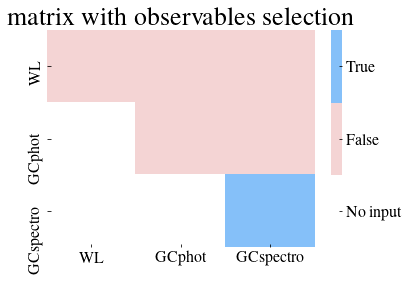

 2022-04-26 07:45:52,895 [CAMB] Importing *global* CAMB.
 2022-04-26 07:45:52,896 [camb] Initialized!
 2022-04-26 07:45:52,908 [model] *WARNING* Theories {camb.transfers, camb} do not appear to be actually used for anything
Time for initialization of the likelihood:  3.824986696243286


In [10]:
from cobaya.model import get_model

from likelihood.auxiliary.yaml_handler import yaml_write
yaml_write('test',info, overwrite=True)
# The `get_model` function of Cobaya imported in the line above needs a yaml or dictionary as an argument
# 
# We measure the time to give us an estimation of how much time it takes to make the initialization of the
# likelihood
t1 = time.time()

# Second: create an instance of the `model` wrapper called model
model = get_model(info)
print('Time for initialization of the likelihood: ', time.time()-t1)
# We need to sample the log posterior to create model.provider.params
logposterior = model.logposterior({})

In [11]:
# Create an instance of the class EuclidLikelihood and initialize it (general case)
like = EuclidLikelihood()
like.initialize()
like.passing_requirements(model, info, **model.provider.params)

# Update the cosmology dictionary with interpolators + basic quantities such as
# P_gg, P_delta...
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], 0.05)

/home/chiara/work/ist_nl_fastpt/likelihood-implementation/likelihood/auxiliary/observables_dealer.py:69: UserWarning: Attention: CLOE only computes cross-correlations for the photometric survey!
  'Attention: CLOE only computes cross-correlations '
/home/chiara/work/ist_nl_fastpt/likelihood-implementation/likelihood/auxiliary/observables_dealer.py:72: UserWarning: Entries ['WL']['GCphot'] and ['GCphot']['GCspec'] are changed to False.
  "Entries ['WL']['GCphot'] and ['GCphot']['GCspec'] "


 2022-04-26 07:46:10,681 [CAMB] Importing *global* CAMB.
 2022-04-26 07:46:10,682 [camb] Initialized!
 2022-04-26 07:46:10,685 [model] *WARNING* Theories {camb.transfers, camb} do not appear to be actually used for anything
 2022-04-26 07:46:16,350 [CAMB] Importing *global* CAMB.
 2022-04-26 07:46:16,350 [camb] Initialized!
 2022-04-26 07:46:16,354 [model] *WARNING* Theories {camb, camb.transfers} do not appear to be actually used for anything


## Non-linear power spectrum

There are now two options to access the non-linear power spectrum:
1. **through the cosmology dictionary**: if the non-linear flag is set to `NL_flag=5`, the `Pgg_spectro` entry of the cosmology dictionary contains the eft non-linear Pgg. This is computed for a set of bias parameters specified in the `info` dictionary, in the `['params']` entry. If they are not specified, the code defaults to the `params.yaml` file in the `configs` folder, i.e. to the matter power spectrum ($b_1=1$, all other parameters set to 0).

2. **through the eft module**: in this case both the redshift and the bias parameters can be specified directly (the latter using a dictionary).

**NOTE**: the `Pgg_spectro` entry of the cosmology dictionary has HARDCODED redshifts. This is done to avoid a 3D interpolation (over $k$,$\mu$,$z$), but still have the `spectro` function redshift dependent as the linear one. The hardcoded redshifts are the ones of the IST:Forecast paper. This means that requesting a power spectrum at $z=0.95$, will result in a $P(k,\mu)$ at $z=1$, the center of the first redshift bins.

### Example 1: access through the cosmology dictionary

In [14]:
# Check the non linear flag
print("Non-linear flag:",like.cosmo.cosmo_dic['NL_flag'])

Non-linear flag: 5


In [15]:
# Set up k, mu vectors and redshift values
kvec = np.logspace(-3,1,1000)
muvec = np.linspace(-1,1,101)
z0 = 0.0
z1 = 1.0

In [16]:
# Select z=1 and put P(k,mu) in an array
zz = z1
pkmu = np.array(like.cosmo.cosmo_dic['Pgg_spectro'](zz, kvec, muvec))
print("k, mu:",pkmu.shape)

k, mu: (1000, 101)


For illustrative purposes here we do the projection to multipoles manually. In CLOE this is done by IST:L, as well as the inclusion of the Alcock-Paczynski effect.

In [17]:
# Project to multipoles
pk_multipoles = np.zeros((3,len(kvec)))
for i in range(3):
    integrand=np.array([pkmu[j]*legendre(2*i)(muvec) for j in range(len(kvec))])
    pk_multipoles[i] = integ.simps(integrand, x=muvec, axis=1) * (4.*i+1)/2

 2022-04-26 08:04:39,614 [matplotlib.font_manager] *WARNING* findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


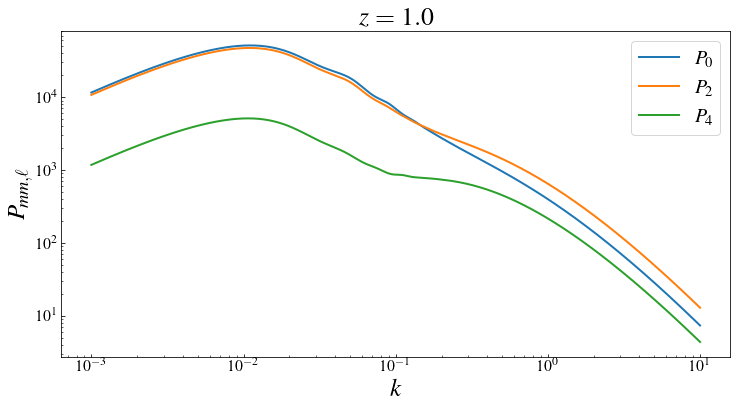

In [18]:
# Plot multipoles -- remember these are matter with no counterterm and no shot noise
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set_title(r'$z={0}$'.format(zz))
plt.plot(kvec, pk_multipoles[0], label=r'$P_0$')
plt.plot(kvec, pk_multipoles[1], label=r'$P_2$')
plt.plot(kvec, pk_multipoles[2], label=r'$P_4$')
ax.set_ylabel(r"$P_{mm,\ell}$")
ax.set_xlabel(r'$k$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()

### Example 2: eft module
Here I access the `P_kmu_z` function of the `eft` module directly, but don't specify the bias parameters, i.e. it's still the matter power spectrum, now computed at redshift $z=0$. This requires importing the `EFTofLSS` module.

In [19]:
from likelihood.non_linear.eft import EFTofLSS
zz = z0 # select redshift zero

# Initialize eftobject and compute loop corrections
eftobj = EFTofLSS(like.cosmo.cosmo_dic)
eftobj._Pgg_kmu_terms()

# Construct anisotropic power spectrum
Pkmu = eftobj.P_kmu_z(f=like.cosmo.cosmo_dic['f_z'](zz), D=like.cosmo.cosmo_dic['D_z_k_func'](zz, 0),
                      **like.cosmo.cosmo_dic) # this is the k,mu interpolator
pkmu_nlmod = Pkmu(kvec, muvec) # compute over the kvec, muvec grid

In [20]:
# Project to multipoles
pk_nlmod = np.zeros((3,len(kvec)))
for i in range(3):
    integrand=np.array([pkmu_nlmod[j]*legendre(2*i)(muvec) for j in range(len(kvec))])
    pk_nlmod[i] = integ.simps(integrand, x=muvec, axis=1) * (4.*i+1)/2

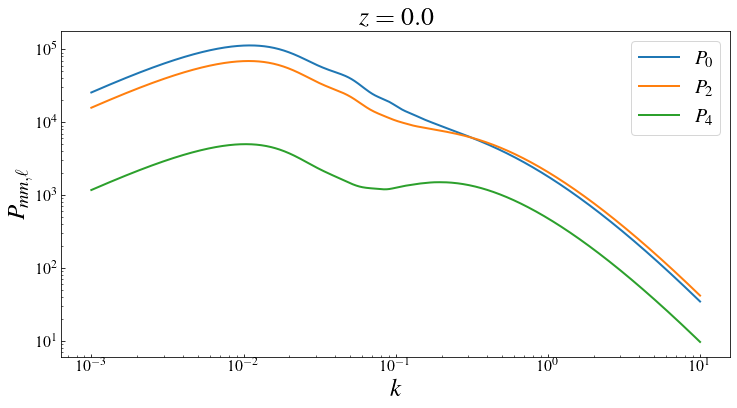

In [21]:
# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set_title(r'$z={0}$'.format(zz))
plt.plot(kvec, pk_nlmod[0], label=r'$P_0$')
plt.plot(kvec, pk_nlmod[1], label=r'$P_2$')
plt.plot(kvec, pk_nlmod[2], label=r'$P_4$')
ax.set_ylabel(r"$P_{mm,\ell}$")
ax.set_xlabel(r'$k$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()

### Example 3: eft module + bias parameters
This is the same as Example 2, i.e. the non-linear power spectrum is accessed directly through the `eft` module, but with a full set of bias parameters.

In [22]:
# Bias parameters are specified in a dictionary
biasdict_z1 = {'b1': 1.369988, 'b2': -0.513959, 'bG2': -0.105710, 'bG3': -0.34522775,
               'c0': 9.542350, 'c2': 11.390455, 'c4': 2.469497, 'cnlo': 12.972343,
               'aP': 0.315394, 'Psn': 489.569369}

In [23]:
# Compute the power spectrum using the bias dictionary
Pkmu = eftobj.P_kmu_z(f=like.cosmo.cosmo_dic['f_z'](zz), D=like.cosmo.cosmo_dic['D_z_k_func'](zz, 0),
                      **biasdict_z1)
pkmu_bias = Pkmu(kvec, muvec)

# Project to multipoles
pk_gg = np.zeros((3,len(kvec)))
for i in range(3):
    integrand=np.array([pkmu_bias[j]*legendre(2*i)(muvec) for j in range(len(kvec))])
    pk_gg[i] = integ.simps(integrand, x=muvec, axis=1) * (4.*i+1)/2

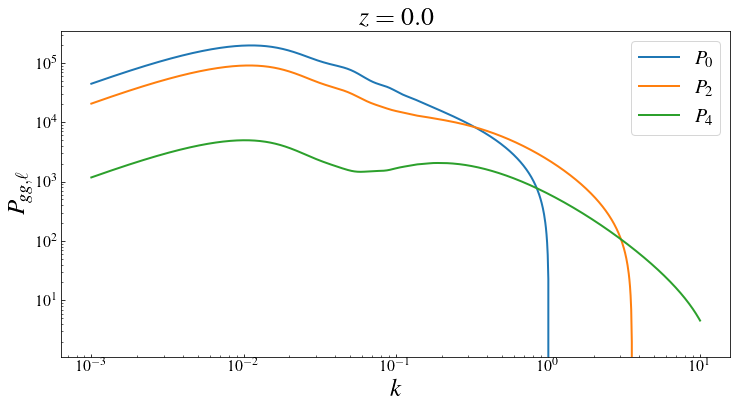

In [24]:
# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set_title(r'$z={0}$'.format(zz))
plt.plot(kvec, pk_gg[0], label=r'$P_0$')
plt.plot(kvec, pk_gg[1], label=r'$P_2$')
plt.plot(kvec, pk_gg[2], label=r'$P_4$')
ax.set_ylabel(r"$P_{gg,\ell}$")
ax.set_xlabel(r'$k$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()